# **Домашняя работа: прогнозирование заработной платы и кластеризация типов движений**

### **Постановка задачи:**

В этой работе две части:

*   В первой части вам предстоит построить алгоритм на основе бустинга для прогнозирования зарплаты
*   Во второй части вам предстоит кластеризовать типы движений по имеющимся данным с акселерометров и гироскопов

### **Оценивание:**

- Как всегда оцениваются как код, так и ответы на вопросы. Если нет одного и/или другого, то часть баллов за соответствующее задание без колебаний снимается.
- Брать код из открытых источников позволительно. Следование культуре цитирования **обязательно.**

### **Баллы:**

Суммарно за задание можно получить 10 основных и 1 бонусный балл.

Оценка за ДЗ = min{ваш балл, 10}

**Мягкий дедлайн: 16 февраля 23:59**

**Интересной вам работы!**


# **Часть 1. Прогнозирование заработной платы при помощи бустинга**

**Количество баллов:** 7

## **Постановка задачи:**

Данные выгружены и лежат в файле `ds_salary.csv`. Вам доступны описания признаков и значения целевой переменной.

**Ваша задача:** построение модели бустинга и оценка данной модели.

## **Описание даных**

- work_year: год, в который взяты данные;
- experience_level: уровень опыта, кодируемый как SE, MI EN или EX
- employment_type: тип занятости (FT, PT, CT, FL)
- job_title: название рабочей позиции в компании;
- salary: зараплата на позиции;
- salary_currency: валюта в которой начисляют зарплату;
- employee_residence: страна или регион проживания сотрудника
- remote_ratio: процент удаленки, предлагаемый в компании (0, 50, 100)
- company_location: местоположение компании
- company_size: размер компании, оцененный как S, M, L
- salary_in_usd: целевая переменная


Как всегда, загрузим набор данных.

In [1]:
!pip install catboost
!pip install category_encoders

In [2]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor
import xgboost as xgb
import lightgbm as lgb
from sklearn.cluster import KMeans, AgglomerativeClustering

from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from category_encoders import TargetEncoder
from sklearn.decomposition import PCA

from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error,\
                            silhouette_score, davies_bouldin_score

from time import time
import joblib

/usr/local/lib/python3.11/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


In [3]:
df = pd.read_csv("https://github.com/hse-ds/iad-intro-ds/raw/refs/heads/master/2023/homeworks/hw-08-boosting/ds_salaries.csv")

## **Задание 1 (0.3 балла)**

Вам даны описания переменных. Проверьте, что категориальные признаки, категории которых перечислены, не имеют ошибочных значений. Для этого:

- Напишите цикл, пробегающий по выбранным признакам и оценивающий, что в них нет лишних значений;

> Столбец **remote_ratio** типа **int**, мне кажется, его можно рассмотреть как категориальный и проверить, что там не содержится лишних значений.

In [4]:
cat_col_check = {'experience_level': ['SE', 'MI', 'EN', 'EX'], 'employment_type': ['FT', 'PT', 'CT', 'FL'],
                 'remote_ratio': [0, 50, 100], 'company_size': ['S', 'M', 'L']}

In [5]:
for column, allowed_values in cat_col_check.items():
    unique_values = set(df[column].dropna().unique())

    if not unique_values.issubset(allowed_values):
        extra_values = unique_values - set(allowed_values)
        print(f'В столбце {column} есть лишние значения: {extra_values}')

## **Задание 2 (0.3 балла)**

Проведите базовые шаги оценки качества данных.
- Есть есть проблемы, устраните их;
- Если нет проблем, кратко опишите это.

In [6]:
df.shape

(3755, 11)

In [7]:
df.head()

,work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
0,2023,SE,FT,Principal Data Scientist,80000,EUR,85847,ES,100,ES,L
1,2023,MI,CT,ML Engineer,30000,USD,30000,US,100,US,S
2,2023,MI,CT,ML Engineer,25500,USD,25500,US,100,US,S
3,2023,SE,FT,Data Scientist,175000,USD,175000,CA,100,CA,M
4,2023,SE,FT,Data Scientist,120000,USD,120000,CA,100,CA,M


In [8]:
df.tail()

,work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
3750,2020,SE,FT,Data Scientist,412000,USD,412000,US,100,US,L
3751,2021,MI,FT,Principal Data Scientist,151000,USD,151000,US,100,US,L
3752,2020,EN,FT,Data Scientist,105000,USD,105000,US,100,US,S
3753,2020,EN,CT,Business Data Analyst,100000,USD,100000,US,100,US,L
3754,2021,SE,FT,Data Science Manager,7000000,INR,94665,IN,50,IN,L


In [9]:
# типы данных
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3755 entries, 0 to 3754
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   work_year           3755 non-null   int64 
 1   experience_level    3755 non-null   object
 2   employment_type     3755 non-null   object
 3   job_title           3755 non-null   object
 4   salary              3755 non-null   int64 
 5   salary_currency     3755 non-null   object
 6   salary_in_usd       3755 non-null   int64 
 7   employee_residence  3755 non-null   object
 8   remote_ratio        3755 non-null   int64 
 9   company_location    3755 non-null   object
 10  company_size        3755 non-null   object
dtypes: int64(4), object(7)
memory usage: 322.8+ KB


In [10]:
'''изменим тип данных для столбца с процентом удаленки,
т.к. признак принимает всего 3 значения: 0, 50, 100'''
df['remote_ratio'] = df['remote_ratio'].astype('object')

In [11]:
# пропуски в данных
df.isna().sum()

,0
work_year,0
experience_level,0
employment_type,0
job_title,0
salary,0
salary_currency,0
salary_in_usd,0
employee_residence,0
remote_ratio,0
company_location,0


In [12]:
df.describe(include='object')

,experience_level,employment_type,job_title,salary_currency,employee_residence,remote_ratio,company_location,company_size
count,3755,3755,3755,3755,3755,3755,3755,3755
unique,4,4,93,20,78,3,72,3
top,SE,FT,Data Engineer,USD,US,0,US,M
freq,2516,3718,1040,3224,3004,1923,3040,3153


In [13]:
df.describe()

,work_year,salary,salary_in_usd
count,3755.000000,3.755000e+03,3755.000000
mean,2022.373635,1.906956e+05,137570.389880
std,0.691448,6.716765e+05,63055.625278
min,2020.000000,6.000000e+03,5132.000000
25%,2022.000000,1.000000e+05,95000.000000
50%,2022.000000,1.380000e+05,135000.000000
75%,2023.000000,1.800000e+05,175000.000000
max,2023.000000,3.040000e+07,450000.000000


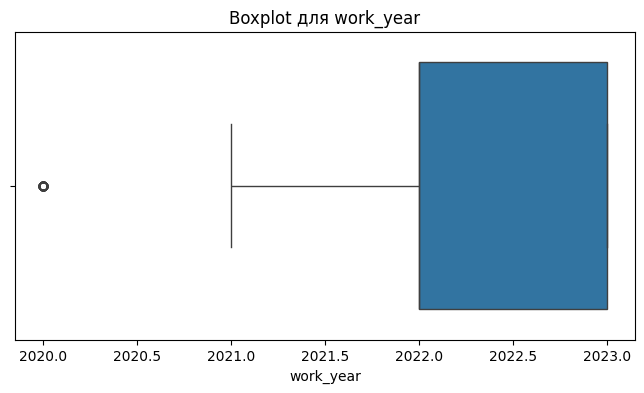

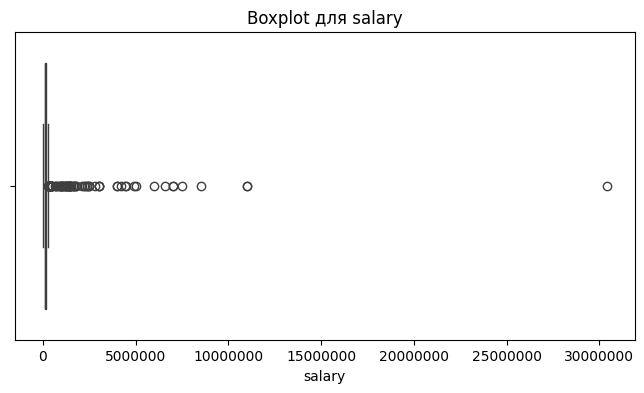

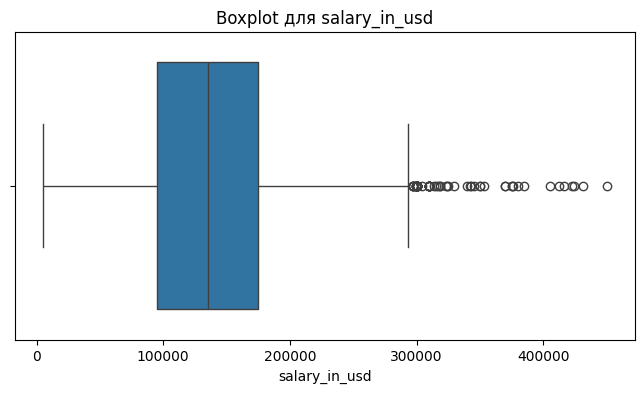

In [14]:
for col in df.select_dtypes(include='int').columns:
    plt.figure(figsize=(8, 4))
    sns.boxplot(x=df[col])
    plt.title(f'Boxplot для {col}')
    plt.ticklabel_format(style='plain', axis='x')
    plt.show()

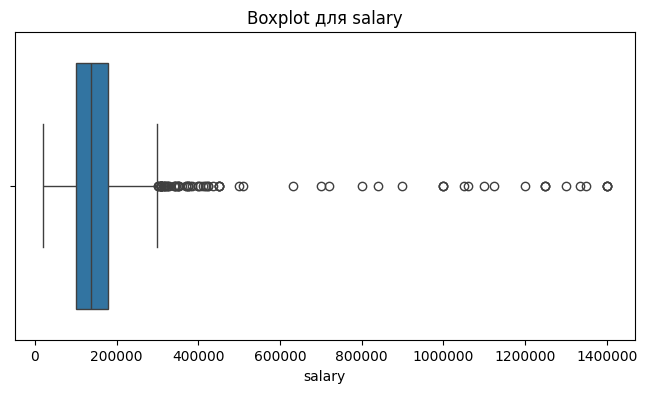

In [15]:
# подробнее boxplot по salary
Q1 = df['salary'].quantile(0.01)
Q3 = df['salary'].quantile(0.99)
df_filtered = df[(df['salary'] >= Q1) & (df['salary'] <= Q3)]

plt.figure(figsize=(8, 4))
sns.boxplot(x=df_filtered['salary'])
plt.title('Boxplot для salary')
plt.ticklabel_format(style='plain', axis='x')
plt.show()

In [16]:
# посмотрим на явный выброс по salary
df[df['salary']==30_400_000]

,work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
3669,2021,MI,FT,Data Scientist,30400000,CLP,40038,CL,100,CL,L


>По базовой проверки есть проблема с масштабом данных. Стандартизируем данные перед обучением модели.  
В остальном:
* Пропущенные значения отсутсвуют,
* Типы данных корректные, за исключением **remote_ratio** (преобразовали с **int** на **object**),
* Описательная статистика явных отклонений или аномалий не показала,
* Выбросы есть, но для обучения модели они могут быть полезны.

>Также, в столбце с зарплатой есть явный выброс - 30.400.000, зарплата указана в чилийских песо, если посмотреть на нее в долларах (40.038), то она в полне реальная, поэтому пока что оставляем все без изменений.  
Есть вопросы к информативности некоторых признаков, но об этом дальше :)

## **Задание 3 (0.3 балла)**

Вернитесь к описанию признаков.
- Проверьте, все ли признаки соответствуют постановке задачи? Если есть лишние признаки, удалите их и обоснуйте удаление, если нет, сделайте вывод о релевантности (достаточно в одну-две строки)
- Зафиксируйте, в каких признаках много категорий.

> Исходя из анализа выше, можно удалить признак **salary** и оставить только **salary_in_usd**, чтобы для каждого объекта зарплата была в одной валюте (долларах) + признак **salary** может сильно коррелировать с таргетом, проверим это ниже.  
Остальные признаки соотвествуют постановке задачи и могут быть важны для прогнозирования зарплаты.

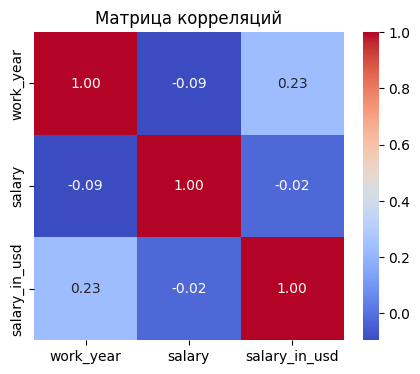

In [17]:
# проверяем корреляцию между salary и salary_in_usd
df_numeric = df.select_dtypes(include=['int64'])
correlation_matrix = df_numeric.corr()

plt.figure(figsize=(5, 4))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Матрица корреляций')
plt.show()

>Между признаками **salary** и **salary_in_usd** отсутствует корреляция. Тем не менее, наличие признака **salary** вызывает у меня сомнения. Пока оставим его в данных. На следующем этапе закодируем категориальные признаки, обучим модель (например, случайный лес) и проанализируем важность признака **salary**.

In [18]:
# кол-во уникальных категорий в признаках
unique_counts = df.nunique()
unique_counts.sort_values(ascending=False)

,0
salary_in_usd,1035
salary,815
job_title,93
employee_residence,78
company_location,72
salary_currency,20
work_year,4
experience_level,4
employment_type,4
remote_ratio,3


>Много категорий в следующих признаках:  
* **salary_in_usd** - зарплата в долларах,
* **salart** - зарплата,
* **job_title** - название рабочей позиции,
* **employee_residence** - регион проживания сотрудника,
* **company_location** - местоположение компании,
* **salary_currency** - валюта, в которой начисляется зарплата.

## **Задание 4 (0.2 балла)**

Разделите выборку на train, test (80%, 20%).

In [19]:
X = df.drop(columns='salary_in_usd', axis=1)
y = df['salary_in_usd']

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## **Задание 5 (0.3 балла)**

Будем проверять два сценария. Первый — построение модели только на непрерывных признаках, а второй — построение с категориальными. В этом задании подготовьте всё, чтобы проверить валидность обоих сценариев. А именно:

- Выделите данные для тренировки и теста для непрерывных признаков
- Выделите данные для тренировки и теста для непрерывных + категориальных признаков, пока ничего не кодируйте.

In [21]:
# неприрывные признаки
X_train_cont, X_test_cont = X_train[['work_year', 'salary']], X_test[['work_year', 'salary']]

>Для непрерывных + категориальных признаков данные разбиты в задание №4.

## **Задание 6 (0.2 балла)**

- Обучите модель линейной регресии на числовых признаках и оцените её качество через mape и rmse;
- Сделайте вывод о качестве построенной модели;

In [22]:
def LinearRegressionModel(Xtrain, Xtest, ytrain):
  model = LinearRegression()
  model.fit(Xtrain, ytrain)

  y_pred = model.predict(Xtest)
  return model, y_pred

In [23]:
def standardize_data(Xtrain, Xtest):
  scaler = StandardScaler()

  Xtrain_scaled = scaler.fit_transform(Xtrain)
  Xtest_scaled = scaler.transform(Xtest)

  Xtrain = pd.DataFrame(Xtrain_scaled, columns=Xtrain.columns)
  Xtest = pd.DataFrame(Xtest_scaled, columns=Xtest.columns)

  return Xtrain, Xtest

In [24]:
# стандартизируем данные
X_train_cont, X_test_cont = standardize_data(X_train_cont, X_test_cont)

In [25]:
model_lr, y_pred_lr = LinearRegressionModel(X_train_cont, X_test_cont, y_train)

In [26]:
rmse_score_lr = np.sqrt(mean_squared_error(y_test, y_pred_lr))
print(f'RMSE линейной регресии на числовых признаках: {rmse_score_lr}')

RMSE линейной регресии на числовых признаках: 61362.98323942841


>Обучаясь всего на двух числовых признаков, странно ожидать от модели хороших результатов, значение rmse сишком большое, мы ошибаемся примерно на 61.000 долларов, что говорит о плохом качестве модели.

>

## **Задание 8 (0.2 балла)**

- Обучите модель бустинга (любую из трех библиотек catboost, xgboost, lightgbm) с гиперпараметрами по умолчанию на непрерывных признаках и оцените её качество через mape и rmse;
- Сделайте вывод о качестве построенной модели;

In [27]:
def CatBoostModel(Xtrain, Xtest, ytrain):
  model = CatBoostRegressor(verbose=False, random_state=42)
  model.fit(Xtrain, ytrain)

  y_pred = model.predict(Xtest)
  return model, y_pred

In [28]:
model_cbr, y_pred_cbr = CatBoostModel(X_train_cont, X_test_cont, y_train)

In [29]:
rmse_cbr = np.sqrt(mean_squared_error(y_test, y_pred_cbr))
mape_cbr = mean_absolute_percentage_error(y_test, y_pred_cbr)

print(f"RMSE: {rmse_cbr:.2f}")
print(f"MAPE: {mape_cbr:.2%}")

RMSE: 18700.98
MAPE: 22.24%


In [30]:
min_salary_usd = df['salary_in_usd'].min()
maх_salary_usd = df['salary_in_usd'].max()
mean_salary_usd = round(df['salary_in_usd'].mean(), 0)

print(f'Диапазон зарплат в долларах - от {min_salary_usd} до {maх_salary_usd}')
print(f'Средняя зарплата в долларах: {mean_salary_usd}')

Диапазон зарплат в долларах - от 5132 до 450000
Средняя зарплата в долларах: 137570.0


>RMSE ~ 18.700, что при нашем диапазоне зарплат и среднем значение в 137.570 не очень хороший результат, т.е. мы ошибаемся примерно на 18.000 долларов от реальной зарплаты.  
MAPE = 22.24%, т.е. в среднем модель ошибается на 22.2% от реальной зарплаты.

>Также, стоит не забывать о предположении, что модель сильно подстаривается под признак **salary**, поэтому результат не супер, но и не сильно плохой.


## **Задание 9 (0.8 балла)**

Теперь подключим категориальные признаки. Но попроубем разные стратегии предобработки.

**1:**
- Предобработайте категориальные признаки при помощи OHE
- Постройте модель бустинга и линейную регрессию
- Оцените качество обеих моделей

**2:**
- Предобработайте категориальные признаки при помощи LabelEncoding
- Постройте модель бустинга и линейную регрессию
- Оцените качество обеих моделей

**3:**
- Предобработайте категориальные признаки при помощи MeanTargetEnc
- Постройте модель бустинга и линейную регрессию
- Оцените качество обеих моделей

Сделайте выводы по построениям 1-3. Выберите лучшую модель и дальше поработайте с ней.

### Стратегия №1

In [31]:
# категориальные признаки
categorical_cols = list(X_train.select_dtypes(include='object').columns)

In [32]:
# кодируем категориальные признаки с помощью OHE
ohe = OneHotEncoder(drop='first', handle_unknown='ignore')

ohe.fit(X_train[categorical_cols])

X_train_met_ohe = pd.DataFrame(ohe.transform(X_train[categorical_cols]).toarray(),
                           columns=ohe.get_feature_names_out(input_features=categorical_cols))

X_test_met_ohe = pd.DataFrame(ohe.transform(X_test[categorical_cols]).toarray(),
                         columns=ohe.get_feature_names_out(input_features=categorical_cols))

# удаляем исходные категориальные признаки
X_train_not_cat = X_train.drop(columns=categorical_cols).reset_index(drop=True)
X_test_not_cat = X_test.drop(columns=categorical_cols).reset_index(drop=True)

X_train_ohe = pd.concat([X_train_not_cat, X_train_met_ohe], axis=1)
X_test_ohe = pd.concat([X_test_not_cat, X_test_met_ohe], axis=1)

/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [2, 3, 4, 6] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(




---



### Небольшое отступление  

>Категориальные признаки закодировали, вернемся к заданию №3, помотрим на сколько важный для модели признак **salary**, не подстраивается ли модель сильно под него:

In [33]:
model_rfr_check = RandomForestRegressor(n_estimators=100, random_state=42)
model_rfr_check.fit(X_train_ohe, y_train)

y_pred_rfr_check = model_rfr_check.predict(X_test_ohe)

In [34]:
mse_rfr = mean_squared_error(y_test, y_pred_rfr_check)
print(f'MSE (случайный лес): {mse_rfr:.2f}')

MSE (случайный лес): 69105851.07


In [35]:
# важность признаков
feature_importances = model_rfr_check.feature_importances_

importance_df = pd.DataFrame({
    'Признак': X_train_ohe.columns,
    'Важность': feature_importances
})

# топ-10 самых важных признаков
importance_df.sort_values(by='Важность', ascending=False).head(10)

,Признак,Важность
1,salary,0.876727
109,salary_currency_USD,0.048673
102,salary_currency_INR,0.040952
146,employee_residence_IN,0.004171
101,salary_currency_ILS,0.003184
218,company_location_IL,0.002524
183,remote_ratio_50,0.001880
9,job_title_AI Scientist,0.001204
145,employee_residence_IL,0.001114
99,salary_currency_GBP,0.001081


>Что и требовалось ожидать, признак **salary** намного важнее остальных признаков, модель очень сильно под него подстраивается. Удалим признах их тренировочных и тестовых данных и далее будем обучать модели без него.

In [36]:
X_train.drop(columns='salary', axis=1, inplace=True)
X_test.drop(columns='salary', axis=1, inplace=True)

X_train_ohe.drop(columns='salary', axis=1, inplace=True)
X_test_ohe.drop(columns='salary', axis=1, inplace=True)



---



>С отступлением закончили, возвращаемся к стратегии №1. Обучим модель бустинга и линейную регрессию.

In [37]:
# стандартизируем данные
X_train_ohe, X_test_ohe = standardize_data(X_train_ohe, X_test_ohe)

In [38]:
# линейная регрессия
model_lr_ohe, y_pred_lr_ohe = LinearRegressionModel(X_train_ohe, X_test_ohe, y_train)

In [39]:
rmse_score_ohe = np.sqrt(mean_squared_error(y_test, y_pred_lr_ohe))
print(f'RMSE линейной регресии на числовых и кат. признаках: {rmse_score_ohe:.2f}')

RMSE линейной регресии на числовых и кат. признаках: 49340.58


In [40]:
# CatBoost
model_cbr_ohe, y_pred_cbr_ohe = CatBoostModel(X_train_ohe, X_test_ohe, y_train)

In [41]:
rmse_cbr_ohe = np.sqrt(mean_squared_error(y_test, y_pred_cbr_ohe))
print(f"RMSE на числовых и кат. признаках (CatBoost): {rmse_cbr_ohe:.2f}")

RMSE на числовых и кат. признаках (CatBoost): 48096.74


> **Вывод по стратегии №1:** Сравнивать линейную регрессию только на числовых и на числовых + кат. признаках, думаю, не стоит, с признаком **salary** метрика было сильно завышена. Если говорить про линейную регрессию и CatBoost на всех данных, то CatBoost показал результат лучше - RMSE практически на 1.000 меньше, но в совокупности обе модели показали слабый результат.

In [42]:
assert X_train.shape == (3_004, 9)
assert X_test.shape == (751, 9)

### Стратегия №2

In [43]:
X_train_le = X_train.copy()
X_test_le = X_test.copy()

# создаем и обучаем LabelEncoder для каждой категориальной колонки
label_encoders = {}
for col in categorical_cols:
  le = LabelEncoder()
  le.fit(X_train[col])
  label_encoders[col] = le

# применяем LabelEncoder к тренировочным данным
for col in categorical_cols:
  X_train_le[col + '_encoded'] = label_encoders[col].transform(X_train_le[col])

'''
Чтобы избежать утечки данных и не обучать кодировщих на всех данных (т.к. в тесте
могут встретиться категории, которых не было в трейне), заменим неизвестные
категории из теста на "-1"
'''
for col in categorical_cols:
    X_test_le[col + '_encoded'] = X_test_le[col].apply(
        lambda x: label_encoders[col].transform([x])[0] if x in label_encoders[col].classes_ else -1)

# удаляем исходные категориальные столбцы
X_train_le = X_train_le.drop(columns=categorical_cols).reset_index(drop=True)
X_test_le = X_test_le.drop(columns=categorical_cols).reset_index(drop=True)

In [44]:
assert X_train.shape == (3_004, 9)
assert X_test.shape == (751, 9)

In [45]:
# стандартизируем данные
X_train_le, X_test_le = standardize_data(X_train_le, X_test_le)

In [46]:
# линейная регрессия
model_lr_le, y_pred_lr_le = LinearRegressionModel(X_train_le, X_test_le, y_train)

In [47]:
rmse_score_le = np.sqrt(mean_squared_error(y_test, y_pred_lr_le))
print(f'RMSE линейной регресии на числовых и кат. признаках: {rmse_score_le:.2f}')

RMSE линейной регресии на числовых и кат. признаках: 52141.31


In [48]:
# CatBoost
model_cbr_le, y_pred_cbr_le = CatBoostModel(X_train_le, X_test_le, y_train)

In [49]:
rmse_cbr_le = np.sqrt(mean_squared_error(y_test, y_pred_cbr_le))
print(f"RMSE на числовых и кат. признаках (CatBoost): {rmse_cbr_le:.2f}")

RMSE на числовых и кат. признаках (CatBoost): 48304.90


>**Вывод по стратегии №2:** с применением LabelEncoder линейная регрессия показала результат хуже, чем с OHE, CatBoost почти без изменений и по метрике опять лучше.

### Стратегия №3

In [50]:
# MeanTargetEnc реализуем через TargetEncoder
encoder = TargetEncoder(cols=categorical_cols, smoothing=1.0)

X_train_enc = encoder.fit_transform(X_train[categorical_cols], y_train)
X_test_enc = encoder.transform(X_test[categorical_cols])

X_train_enc = pd.DataFrame(X_train_enc, columns=categorical_cols)

# возвращаем числовой столбец с годом
X_train_enc['work_year'] = X_train['work_year']
X_test_enc['work_year'] = X_test['work_year']

In [51]:
assert X_train.shape == (3_004, 9)
assert X_test.shape == (751, 9)

In [52]:
# стандартизируем данные
X_train_enc, X_test_enc = standardize_data(X_train_enc, X_test_enc)

In [53]:
# линейная регрессия
model_lr_enc, y_pred_lr_enc = LinearRegressionModel(X_train_enc, X_test_enc, y_train)

In [54]:
rmse_score_enc = np.sqrt(mean_squared_error(y_test, y_pred_lr_enc))
print(f'RMSE линейной регресии на числовых и кат. признаках: {rmse_score_enc:.2f}')

RMSE линейной регресии на числовых и кат. признаках: 49313.37


In [55]:
# CatBoost
model_cbr_enc, y_pred_cbr_enc = CatBoostModel(X_train_enc, X_test_enc, y_train)

In [56]:
rmse_cbr_enc = np.sqrt(mean_squared_error(y_test, y_pred_cbr_enc))
print(f"RMSE на числовых и кат. признаках (CatBoost): {rmse_cbr_enc:.2f}")

RMSE на числовых и кат. признаках (CatBoost): 47569.51


> **Вывод по стратегии №3:** при применении TargetEncoder модель CatBoost показала результат лучше, чем линейная регрессия почти на 2.000.

>**Общий вывод:** лучший результат получился с применением TargetEncoder и CatBoost. RMSE ~ 47к. Результат опять же не очень хороший, дальше попробуем улучшить метрику.

## **Задание 10 (0.5 балла)**

Покажите, где ошибается ваша модель. Выведите топ 20 примеров с наибольшей ошибкой. Проанализируйте их. Какие выводы можно сделать? Что стоит изменить в данных чтобы улучшить качество модели?

In [57]:
errors = abs(y_pred_cbr_enc - y_test)
top_20_errors = X_test.copy()
top_20_errors['errors'] = errors
top_20_errors.sort_values(by='errors', ascending=False).head(20)

,work_year,experience_level,employment_type,job_title,salary_currency,employee_residence,remote_ratio,company_location,company_size,errors
1288,2023,SE,FT,Data Analyst,USD,US,0,US,M,253916.084728
1105,2023,SE,FT,Data Scientist,USD,US,0,US,M,200602.338330
2589,2022,SE,FT,Product Data Scientist,USD,IN,100,SG,L,185862.615367
2359,2022,SE,FT,Data Science Tech Lead,USD,US,50,US,L,157724.608920
1116,2023,SE,FT,Machine Learning Engineer,USD,US,0,US,M,150102.918622
3713,2020,SE,FT,Data Scientist,USD,US,50,US,L,148518.079810
1593,2023,SE,FT,Data Engineer,USD,US,0,US,M,141509.536648
33,2023,SE,FT,Computer Vision Engineer,USD,US,0,US,M,139779.888604
3609,2020,SE,FT,Machine Learning Scientist,USD,JP,0,JP,S,136415.658596
746,2023,EX,FT,Data Engineer,USD,US,100,US,M,131015.582930


>Чаще всего модель ошибается на вакансиях с уровнем опыта - SE (Senior). По графикам выше мы видели выбросы в зарплатах. Можно попробовать заменить выбросы медианым значением по названию позиции, уровню позиции, локации компании и сотрдуника.

## **Задание 11 (0.5 балла)**

Придумайте признаки для улучшения качества модели на основе предыдущего пункта. Как вам кажется какими признаками можно улучшить качетсво модели? Реализуйте признаки и проверьте улучшилось ли качество модели.

**Примечание:**
Полный балл за задание ставится даже при отсутствии улучшения качества модели, важно попробовать проверить свои гипотезы и сделать выводы.

>Заменим выбросы в зарплате на медианную по группе:

In [58]:
# выбросы
Q1 = df['salary_in_usd'].quantile(0.25)
Q3 = df['salary_in_usd'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

df['median_salary'] = df.groupby(['job_title', 'experience_level', 'employee_residence',
                                  'company_location'])['salary_in_usd'].transform('median')

# заменим выбросы на медианные значения
df_new = df.copy()
df_new['salary_in_usd'] = np.where(
    (df_new['salary_in_usd'] < lower_bound) | (df_new['salary_in_usd'] > upper_bound),
    df_new['median_salary'],
    df_new['salary_in_usd']
)

df_new.drop(columns=['median_salary'], inplace=True)

>Добавим признак, который будет показывать отношение зарплаты к медианной зарплаты по группе:

In [59]:
df_new['median_salary_by_group'] = df_new.groupby(['job_title', 'experience_level',
                                                   'employee_residence', 'company_location'])['salary_in_usd'].transform('median')

df_new['salary_to_median_ratio'] = df_new['salary_in_usd'] / df_new['median_salary_by_group']

# удаляем всапомогательный столбец и столбец с ЗП
df_new.drop(columns=['median_salary_by_group', 'salary'], inplace=True)

>Обучим модель на преобразованных данных:

In [60]:
X_new = df_new.drop(columns='salary_in_usd', axis=1)
y_new = df_new['salary_in_usd']

In [61]:
X_train_new, X_test_new, y_train_new, y_test_new = train_test_split(X_new, y_new, test_size=0.2, random_state=42)

In [62]:
assert X_train_new.shape == (3_004, 10)
assert X_test_new.shape == (751, 10)

In [63]:
X_train_new.head()

,work_year,experience_level,employment_type,job_title,salary_currency,employee_residence,remote_ratio,company_location,company_size,salary_to_median_ratio
2238,2022,SE,FT,Data Engineer,EUR,ES,0,ES,M,0.666667
485,2023,MI,FT,Research Scientist,USD,US,100,US,M,1.008973
2177,2022,SE,FT,Data Analyst,USD,US,0,US,M,0.861790
3305,2022,SE,FT,Data Engineer,USD,US,100,US,M,1.044000
1769,2023,SE,FT,Data Engineer,USD,US,100,US,M,1.166667


In [64]:
# кодируем данные с помощью TargetEncoder
encoder_new = TargetEncoder(cols=categorical_cols, smoothing=1.0)

X_train_new_enc = encoder_new.fit_transform(X_train_new[categorical_cols], y_train_new)
X_test_new_enc = encoder_new.transform(X_test_new[categorical_cols])

X_train_new_enc = pd.DataFrame(X_train_new_enc, columns=categorical_cols)

X_train_new_enc['work_year'] = X_train_new['work_year']
X_train_new_enc['salary_to_median_ratio'] = X_train_new['salary_to_median_ratio']

X_test_new_enc['work_year'] = X_test_new['work_year']
X_test_new_enc['salary_to_median_ratio'] = X_test_new['salary_to_median_ratio']

In [65]:
assert X_train_new_enc.shape == (3_004, 10)
assert X_test_new_enc.shape == (751, 10)

In [66]:
# CatBoost
model_cbr_new_enc, y_pred_cbr_new_enc = CatBoostModel(X_train_new_enc, X_test_new_enc, y_train_new)

In [67]:
rmse_cbr_new_enc = np.sqrt(mean_squared_error(y_test_new, y_pred_cbr_new_enc))
print(f"RMSE на преобразованных данных (CatBoost): {rmse_cbr_new_enc:.2f}")

RMSE на преобразованных данных (CatBoost): 19507.78


>Добавление новых признаков позволило улучшить значение RMSE почти в 2.4 раза - с 47к до 19к. Ниже посмотрим на значение метрики у CatBoost без кодирование признаков, т.к. данная модель может кодировать категориальные признаки самостоятельно.

## **Задание 12 (1 балл)**

Поупражняемся с разными бустингами!

- Используйте catboost.
- Обучите модель — на полном наборе данных с категориальными признаками.
- Подберите оптимальные гиперпараметры.
- Оцените качество итоговой модели, скорость обучения и скорость предсказания.


**Примечание:**
Замерять скорость = смотреть, как долго исполняется код.

In [68]:
# обучаем CatBoost на всех преобразованных данных без кодировки
model_cbr_lite = CatBoostRegressor(
    iterations=1000,
    learning_rate=0.1,
    depth=6,
    loss_function='RMSE',
    verbose=100
)

start_time = time()
model_cbr_lite.fit(X_train_new, y_train_new, cat_features=categorical_cols)
training_time = time() - start_time

print(f"Время обучения: {training_time:.2f} секунд")

0:	learn: 54792.2959660	total: 23.4ms	remaining: 23.3s
100:	learn: 18070.9651027	total: 2.47s	remaining: 22s
200:	learn: 15371.4818682	total: 5.42s	remaining: 21.6s
300:	learn: 13579.9808793	total: 7.31s	remaining: 17s
400:	learn: 12404.5009545	total: 9.48s	remaining: 14.2s
500:	learn: 11427.2541852	total: 11s	remaining: 11s
600:	learn: 10683.8437783	total: 11.8s	remaining: 7.81s
700:	learn: 10022.2838812	total: 12.5s	remaining: 5.34s
800:	learn: 9441.4459533	total: 13.3s	remaining: 3.3s
900:	learn: 8954.2954509	total: 14.1s	remaining: 1.54s
999:	learn: 8528.9539288	total: 15s	remaining: 0us
Время обучения: 15.28 секунд


In [69]:
y_pred_cbr_lite = model_cbr_lite.predict(X_test_new)
rmse_cbr_lite = np.sqrt(mean_squared_error(y_test_new, y_pred_cbr_lite))
print(f"RMSE без подбора гиперпараметров: {rmse_cbr_lite:.2f}")

RMSE без подбора гиперпараметров: 20233.81


In [70]:
# # подбор гиперпараметров
# model_cbr_search = CatBoostRegressor(cat_features=categorical_cols, verbose=0)

# param_dist = {
#     'depth': [4, 6, 8],
#     'learning_rate': [0.01, 0.1],
#     'iterations': [500, 1000, 1500],
# }

# random_search = RandomizedSearchCV(
#     estimator=model_cbr_search,
#     param_distributions=param_dist,
#     n_iter=20,
#     cv=3,
#     scoring='neg_mean_squared_error',
#     n_jobs=-1,
#     verbose=1,
#     random_state=42
# )

# start_time = time()
# random_search.fit(X_train_new, y_train_new)
# end_time = time()

# print("Лучшие гиперпараметры:", random_search.best_params_)
# print(f"Время подбора гиперпараметров: {end_time - start_time:.2f} секунд")

>Лучшие гиперпараметры: {'learning_rate': 0.1, 'iterations': 1500, 'depth': 6}  
Время подбора гиперпараметров: 560.49 секунд

In [71]:
# # обучаем CatBoost на подобранных параметрах
# best_model_cbr = CatBoostRegressor(
#     iterations=random_search.best_params_['iterations'],
#     learning_rate=random_search.best_params_['learning_rate'],
#     depth=random_search.best_params_['depth'],
#     loss_function='RMSE',
#     verbose=100
# )

# start_time = time()
# best_model_cbr.fit(X_train_new, y_train_new, cat_features=categorical_cols)
# best_training_time = time() - start_time

# print(f"Время обучения с лучшими параметрами: {best_training_time:.2f} секунд")

> Время обучения с лучшими параметрами: 13.08 секунд

In [72]:
# joblib.dump(best_model_cbr, 'catboost_best_model.pkl')

In [73]:
best_model_cbr = joblib.load('/content/catboost_best_model.pkl')

In [74]:
start_time = time()
y_pred_best_cbr = best_model_cbr.predict(X_test_new)
prediction_time = time() - start_time

rmse_best_cbr = np.sqrt(mean_squared_error(y_test_new, y_pred_best_cbr))

print(f"RMSE: {rmse_best_cbr:.2f}")
print(f"Время предсказания: {prediction_time:.2f} секунд")

RMSE: 20039.42
Время предсказания: 0.02 секунд


>Побор гиперпараметров улучшил метрику незначительно. Подбор гиперпараметров занял около 9 минут, обучение модели на подобранных гиперпараметрах - 13 с., предсказание - 0.01 с.  
CatBoost на данных с кодировкой показал результат лучше, чем без неё и подбором гиперпараметров.

## **Задание 13 (1 балл)**

- Используйте xgboost.
- Обучите модель — на полном наборе данных с категориальными признаками. Стратегию кодирования оставьте ту, что показала себя лучшей в пункте 9.
- Подберите оптимальные гиперпараметры.
- Оцените качество итоговой модели, скорость обучения и скорость предсказания.



In [75]:
# XGboost c параметрами по умолчанию
xgb_model_lite = xgb.XGBRegressor(objective='reg:squarederror', eval_metric='rmse', random_state=42)

start_time = time()
xgb_model_lite.fit(X_train_new_enc, y_train_new)
training_time_default = time() - start_time
print(f"Время обучения: {training_time_default:.2f} секунд")

Время обучения: 0.23 секунд


In [76]:
start_time = time()
y_pred_xgb_lite = xgb_model_lite.predict(X_test_new_enc)
prediction_time_default = time() - start_time
rmse_default = np.sqrt(mean_squared_error(y_test_new, y_pred_xgb_lite))

print(f"Время предсказания: {prediction_time_default:.2f} секунд")
print(f"RMSE без подбора гиперпараметров: {rmse_default:.2f}")

Время предсказания: 0.04 секунд
RMSE без подбора гиперпараметров: 19772.38


In [77]:
# # подбор гиперпараметров
# param_dist = {
#     'max_depth': [3, 5, 7, 9],
#     'learning_rate': [0.01, 0.1],
#     'n_estimators': [100, 200, 300],
#     'subsample': [0.6, 0.8, 1.0],
#     'colsample_bytree': [0.6, 0.8, 1.0],
#     'gamma': [0, 0.1, 0.2],
#     'min_child_weight': [1, 3, 5]
# }

# random_search = RandomizedSearchCV(
#     estimator=xgb.XGBRegressor(objective='reg:squarederror', eval_metric='rmse', random_state=42),
#     param_distributions=param_dist,
#     n_iter=20,
#     scoring='neg_root_mean_squared_error',
#     cv=3,
#     verbose=1,
#     random_state=42
# )

# start_time = time()
# random_search.fit(X_train_new_enc, y_train_new)
# search_time = time() - start_time
# print(f"Время подбора гиперпараметров: {search_time:.2f} секунд")

# best_params = random_search.best_params_
# print("Лучшие гиперпараметры:", best_params)

Время подбора гиперпараметров: 23.04 секунд  
Лучшие гиперпараметры: {'subsample': 0.8, 'n_estimators': 300, 'min_child_weight': 3, 'max_depth': 5, 'learning_rate': 0.1, 'gamma': 0.1, 'colsample_bytree': 0.6}

In [78]:
# joblib.dump(best_model_xgb, 'xgboost_best_model.pkl')

In [79]:
best_model_xgb = joblib.load('/content/xgboost_best_model.pkl')

In [80]:
# # Обучаем XGboost c лучшими параметрами
# best_model_xgb = xgb.XGBRegressor(**best_params, objective='reg:squarederror', eval_metric='rmse', random_state=42)

# start_time = time()
# best_model_xgb.fit(X_train_new_enc, y_train_new)
# training_time_best = time() - start_time
# print(f"Время обучения (с лучшими гиперпараметрами): {training_time_best:.2f} секунд")

>Время обучения (с лучшими гиперпараметрами): 0.17 секунд

In [81]:
start_time = time()
y_pred_best_xgb = best_model_xgb.predict(X_test_new_enc)
prediction_time_best = time() - start_time
print(f"Время предсказания (с лучшими гиперпараметрами): {prediction_time_best:.2f} секунд")

rmse_best_xgb = np.sqrt(mean_squared_error(y_test_new, y_pred_best_xgb))
print(f"RMSE (с лучшими гиперпараметрами): {rmse_best_xgb:.2f}")

Время предсказания (с лучшими гиперпараметрами): 0.02 секунд
RMSE (с лучшими гиперпараметрами): 18872.71


>Подбор гиперпараметров помог уменьшить значение RMSE ~ на 1.000. Подбор гиперпараметров занял 23 с., обучение с подобранными параметрами - 0.17 с., предсказание - 0.01 с.  
На данный момент это лучшее значение метрики (RMSE = 18.873).

## **Задание 14 (1 балл)**

- Используйте lgbm.
- Обучите модель — на полном наборе данных с категориальными признаками. Стратегию кодирования оставьте ту, что показала себя лучшей в пункте 9.
- Подберите оптимальные гиперпараметры.
- Оцените качество итоговой модели, скорость обучения и скорость предсказания.


In [82]:
# LightGBM с параметрами по умолчанию
lgbm_model_lite = lgb.LGBMRegressor(objective='regression', random_state=42)

start_time = time()
lgbm_model_lite.fit(X_train_new_enc, y_train_new)
training_time_default = time() - start_time
print(f"Время обучения: {training_time_default:.2f} секунд")

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000692 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 455
[LightGBM] [Info] Number of data points in the train set: 3004, number of used features: 10
[LightGBM] [Info] Start training from score 135768.959554
Время обучения: 0.16 секунд


In [83]:
start_time = time()
y_pred_lgbm_lite = lgbm_model_lite.predict(X_test_new_enc)
prediction_time_default = time() - start_time
print(f"Время предсказания: {prediction_time_default:.2f} секунд")

rmse_lgbm_lite = np.sqrt(mean_squared_error(y_test_new, y_pred_lgbm_lite))
print(f"RMSE без подбора гиперпараметров: {rmse_lgbm_lite:.4f}")

Время предсказания: 0.01 секунд
RMSE без подбора гиперпараметров: 20932.3025


In [84]:
# # подбор гиперпараметров
# param_dist = {
#     'num_leaves': [31, 50, 100, 200],
#     'max_depth': [-1, 3, 5, 7, 10],  #
#     'learning_rate': [0.01, 0.05, 0.1, 0.2],
#     'n_estimators': [100, 200, 300, 400],
#     'subsample': [0.6, 0.8, 1.0],
#     'colsample_bytree': [0.6, 0.8, 1.0],
#     'min_child_samples': [10, 20, 30],
#     'reg_alpha': [0, 0.1, 0.5],
#     'reg_lambda': [0, 0.1, 0.5]
# }

# random_search = RandomizedSearchCV(
#     estimator=lgb.LGBMRegressor(objective='regression', random_state=42),
#     param_distributions=param_dist,
#     n_iter=20,
#     scoring='neg_root_mean_squared_error',
#     cv=3,
#     verbose=1,
#     random_state=42
# )

# start_time = time()
# random_search.fit(X_train_new_enc, y_train_new)
# search_time = time() - start_time
# print(f"Время подбора гиперпараметров: {search_time:.2f} секунд")

# best_params = random_search.best_params_
# print("Лучшие гиперпараметры:", best_params)

>Время подбора гиперпараметров: 14.23 секунд  
Лучшие гиперпараметры: {'subsample': 0.6, 'reg_lambda': 0, 'reg_alpha': 0, 'num_leaves': 50, 'n_estimators': 300, 'min_child_samples': 10, 'max_depth': 5, 'learning_rate': 0.1, 'colsample_bytree': 0.6}

In [85]:
# joblib.dump(best_lgbm, 'lgbm_best_model.pkl')

In [86]:
best_lgbm = joblib.load('/content/lgbm_best_model.pkl')

In [87]:
# best_lgbm = lgb.LGBMRegressor(**best_params, objective='regression', random_state=42)

# start_time = time()
# best_lgbm.fit(X_train_new_enc, y_train_new)
# training_time_best = time() - start_time
# print(f"Время обучения (с лучшими гиперпараметрами): {training_time_best:.2f} секунд")

>Время обучения (с лучшими гиперпараметрами): 0.27 секунд

In [88]:
start_time = time()
y_pred_best_lgmb = best_lgbm.predict(X_test_new_enc)
prediction_time_best = time() - start_time
print(f"Время предсказания (с лучшими гиперпараметрами): {prediction_time_best:.2f} секунд")

rmse_best_lgbm = np.sqrt(mean_squared_error(y_test_new, y_pred_best_lgmb))
print(f"RMSE (с лучшими гиперпараметрами): {rmse_best_lgbm:.2f}")

Время предсказания (с лучшими гиперпараметрами): 0.02 секунд
RMSE (с лучшими гиперпараметрами): 20371.17


>Подбор гиперпараметров незначительно улучшил метрику. Подбор параметров занял 14 с., обучение модели на лучших гиперпараметрах - 0.27 с., время предсказания - 0.02 с.

## **Задание 15 (0.4 балла)**

Сделайте выводы про модели и решение задачи.

- Какая из моделей показала лучший результат по качеству?
- Какая из моделей показала лучший результат по качеству, скорости обучения и скорости предсказания в совокупности?
- Насколько бустинги превзошли линейную модель? Целесообразно ли их использование?

>Лучший результат у XGboost (RMSE = 18.873) с подбором гиперпараметров на закодированных признаках с помощью TargetEncoder. XGboost показал лучший результат по метрке и по скорости подбора гиперпараметров тоже отработал быстро.  
У линейной модели лучший показатель RMSE был около 49.313, что в 2,6 раза больше, чем у XGboost, поэтому модели бустинга одназначно целесообразно использовать.

# **Часть 2: кластеризация типов движений**
**Количество баллов:** 3

В этой части будем работать с набором данных Samsung Human Activity Recognition. Набор данных заранее предобработан и снова доступен вам по [ссылке](https://drive.google.com/file/d/16ISu7lMumt5rbticbOggHMRjwTGBETtO/view?usp=sharing).

### **Постановка задачи**
Данные поступают с акселерометров и гироскопов мобильных телефонов Samsung Galaxy S2. Вид активности человека с телефоном в кармане известен:
- 1 - ходьба,
- 2 - подъем вверх по лестнице,
- 3 - спуск по лестнице,
- 4 - сидение,
- 5 - стояние,
- 6 - лежание


Представим, что вид активности нам неизвестнен, и попробуем кластеризовать людей чисто на основе имеющихся признаков.

In [89]:
plt.style.use(['seaborn-v0_8-darkgrid'])
plt.rcParams['figure.figsize'] = (12, 9)
plt.rcParams['font.family'] = 'DejaVu Sans'

%matplotlib inline
%config InlineBackend.figure_format="retina"

RANDOM_STATE = 42

### **Задание 16 (0.1 балл)**
Прочитайте данные из файлов и объедните тестовую и обучающие выборки.

В файлах ```..._labels``` лежат настоящие классы. Их также объедините, но в отдельную переменную (например ```y```). Данный вектор для кластеризации нам не нужен, но мы будем смотреть по нему метрики.

In [90]:
x1 = pd.read_csv('/content/samsung_train.txt', sep='\s+', header=None)
x2 = pd.read_csv('/content/samsung_test.txt', sep='\s+', header=None)

y1 = pd.read_csv('/content/samsung_train_labels.txt', sep='\s+', header=None)
y2 = pd.read_csv('/content/samsung_test_labels.txt', sep='\s+', header=None)

In [91]:
X = pd.concat([x1, x2], axis=0, ignore_index=True)
y = pd.concat([y1, y2], axis=0, ignore_index=True)

In [92]:
# убедимся, что y содержит нужные нам классы
np.unique(y)

array([1, 2, 3, 4, 5, 6])

### **Задание 17 (0.2 балла)**

Так как мы будем пользоваться метрическими алгоритмами, отмасштабируйте выборку с помощью ```StandardScaler```.

In [93]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_scaled = pd.DataFrame(X_scaled, columns=X.columns)

### **Задание 18 (0.5 балла)**

Данных много и размерность большая. Чтобы ускорить рещение задачи с точки зрения построения модели, мы используем методы **понижения размерности**.

- Понизьте размерность с помощью `PCA`, оставляя столько компонент, сколько нужно для того, чтобы объяснить как минимум 90% дисперсии отмасштабированных данных. Вам пригодится [документация](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html)

**Примечание:**
Для этого сумма значений массива pca.explained_variance_ratio_ должна быть не меньше 0.9.  ```random_state``` используйте из объявленной в самом начале переменной ```RANDOM_STATE``` (42).

In [94]:
pca = PCA(n_components=0.9, random_state=RANDOM_STATE)
X_pca = pca.fit_transform(X_scaled)

explained_variance_ratio = pca.explained_variance_ratio_.sum()

print(f"Количество оставленных компонент: {pca.n_components_}")
print(f"Объясненная дисперсия: {explained_variance_ratio:.2f}")

Количество оставленных компонент: 65
Объясненная дисперсия: 0.90


### **Задание 19 (0.2 балла)**

Визуализируйте данные в проекции на первые две главные компоненты. Используйте ```cmap="virdis"``` или любой другой, с которым будет красиво!

Можете раскрасить кластеры.

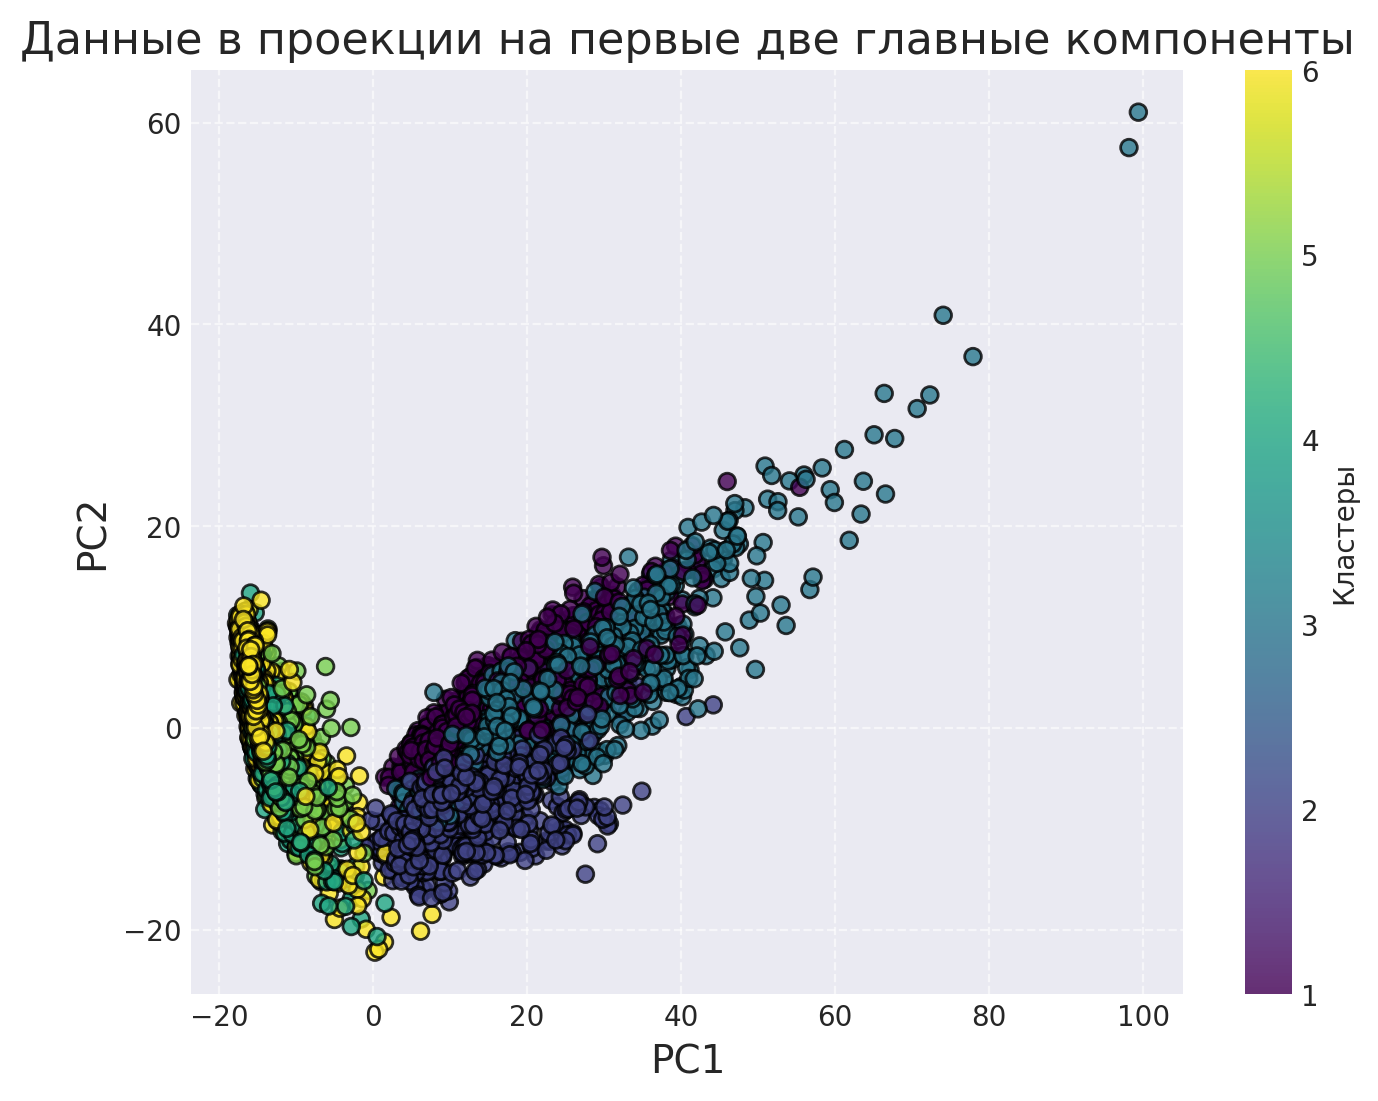

In [95]:
plt.figure(figsize=(8, 6))

scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, cmap="viridis", alpha=0.8, edgecolor='k')
plt.colorbar(scatter, label="Кластеры")

plt.title("Данные в проекции на первые две главные компоненты", fontsize=16)
plt.xlabel("PC1", fontsize=14)
plt.ylabel("PC2", fontsize=14)
plt.grid(True, linestyle='--', alpha=0.6)

plt.show()

### **Задание 19. (0.5 балла)**

Разберёмся с `KMeans`, [doc](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html)

- Сделайте кластеризацию данных методом `KMeans`, обучив модель на данных со сниженной за счет `PCA` размерностью. Нужно искать 6 кластеров (изначально у нас 6 классов). Засеките время обучения и время инференса.

**Параметры обучения:**

```n_clusters = 6``` (число уникальных меток целевого класса = 6)

```n_init = 100```

```random_state = RANDOM_STATE``` (для воспроизводимости результата, не забывайте указывать его и дальше!)

In [96]:
# параметры для KMeans
n_clusters = 6
n_init = 100
random_state = RANDOM_STATE

kmeans = KMeans(n_clusters=n_clusters, n_init=n_init, random_state=random_state)

# время обучения
start_time = time()
kmeans.fit(X_pca)
training_time = time() - start_time

# время предсказания
start_time = time()
y_pred_kmeans = kmeans.predict(X_pca)
predict_time = time() - start_time

print(f'Время обучения: {training_time:.2f} сек.')
print(f'Время предсказания: {predict_time:.2f} сек.')

Время обучения: 11.48 сек.
Время предсказания: 0.00 сек.


### **Задание 20 (0.2 балла)**

- Визуализируйте данные в проекции на первые две главные компоненты.
- Раскрасьте точки в соответствии с полученными метками кластеров.

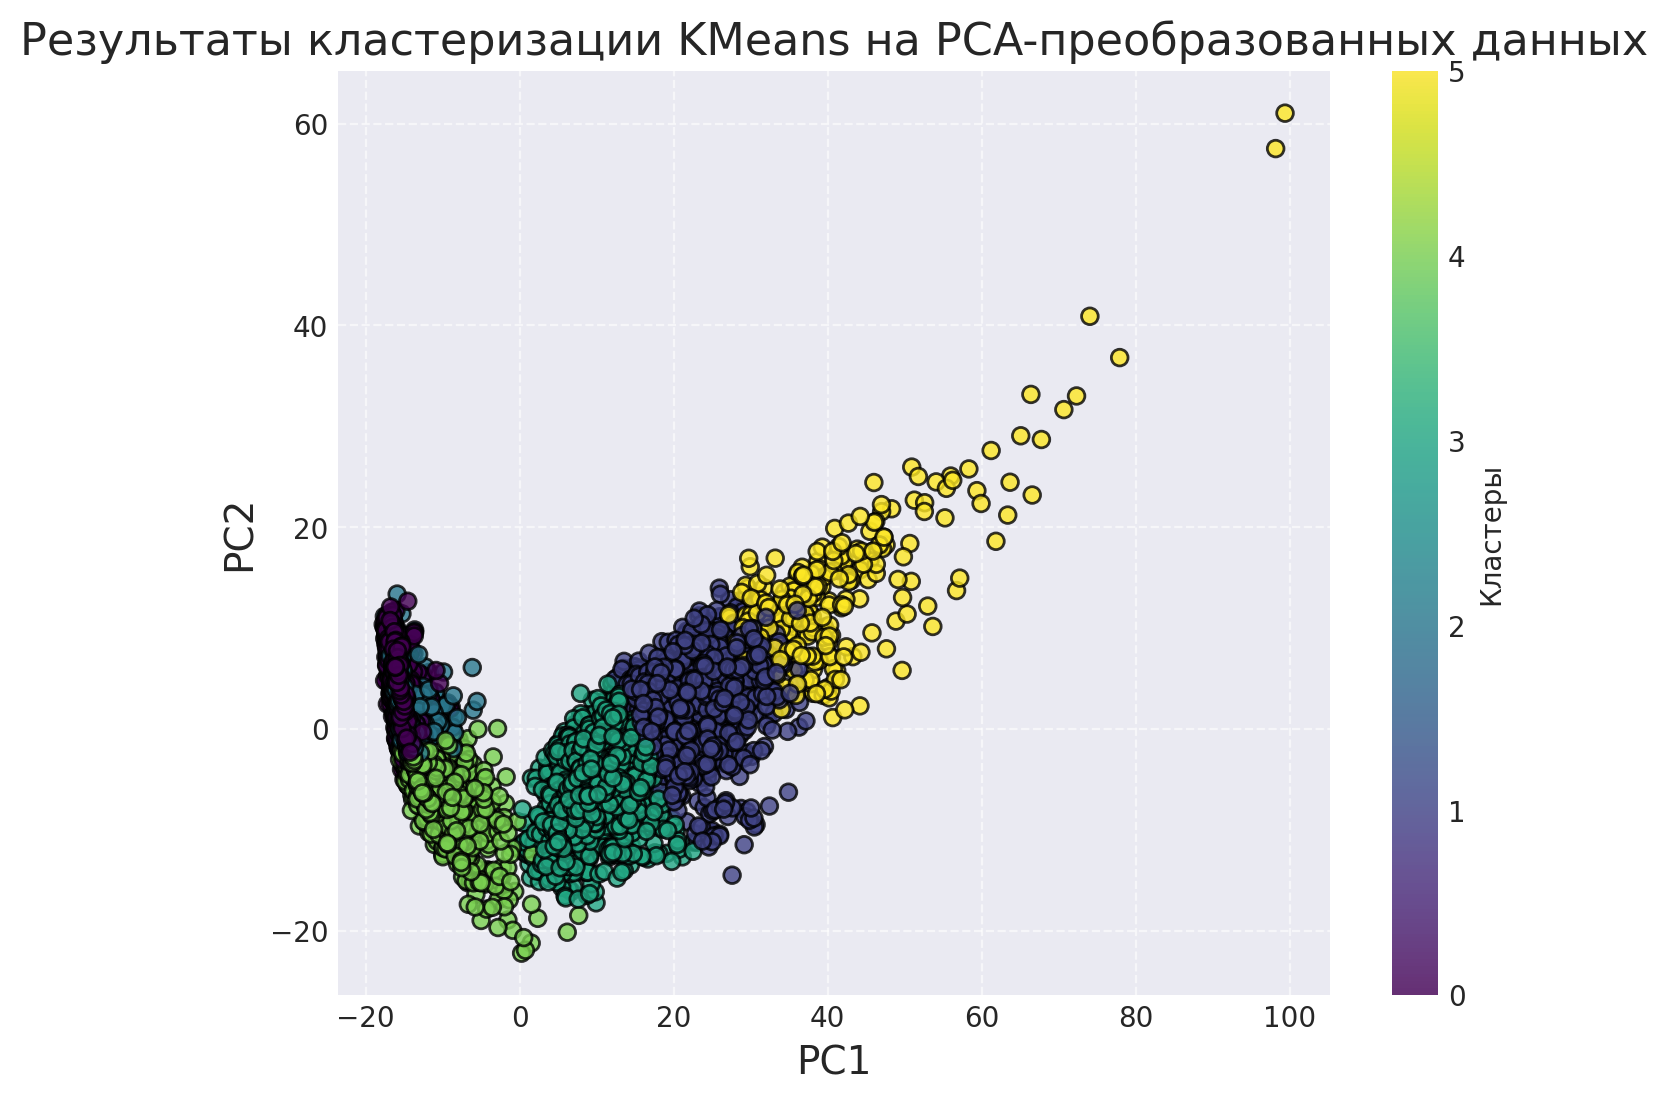

In [97]:
plt.figure(figsize=(8, 6))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_pred_kmeans, cmap="viridis", alpha=0.8, edgecolor='k')
plt.colorbar(scatter, label="Кластеры")
plt.title("Результаты кластеризации KMeans на PCA-преобразованных данных", fontsize=16)
plt.xlabel("PC1", fontsize=14)
plt.ylabel("PC2", fontsize=14)
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

### **Задание 21 (0.3 балла)**

- Выберите какие-то метрики (минимум две) из известных вам. Объясните свой выбор
- Выведите на экран значения метрик качества, сделайте вывод о них и используйте их далее.

>Возьмем 2 метрики:
1. *Silhouette Score* - посотрим как объекты внутри кластеров схожи друг с другом и отличаются от объектов в других кластерах
2. *Davies-Bouldin Index* - измерим среднее сходство между кластерами

Источник: [Метрики качества машинного обучения](https://sky.pro/wiki/python/metriki-kachestva-mashinnogo-obucheniya/)

In [98]:
silhouette_metric = silhouette_score(X_pca, y_pred_kmeans)
davies_bouldin_metric = davies_bouldin_score(X_pca, y_pred_kmeans)

print(f"Средний силуэтный коэффицент: {silhouette_metric:.2f}")
print(f"Индекс Дэвиса-Болдина: {davies_bouldin_metric:.2f}")

Средний силуэтный коэффицент: 0.14
Индекс Дэвиса-Болдина: 2.05


>Значение метрики *Silhouette Score* варьируется от -1 до 1. У нас получилось **0.14**, это говорит о том, что классы сильно пересекаются и имеют плохую структурировоность.  
Значение метрики *Davies-Bouldin Index* - 2.05, тоже плохой показатель, свидетельствующий о том, что кластеры нечетко отделены.


### **Задание 22 (0.7 баллов)**

Теперь попробуем сделать кластеризацию с помощью `AgglomerativeClustering`, [doc](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.AgglomerativeClustering.html)

- Засеките время обучения и время инференса. После кластеризации также:
  - Вновь визуализируйте данные с раскраской по полученным меткам
  - Выведите метрики. Засеките время обучения и время инференса. Сравните с ```KMeans```.

Ответьте на следующие вопросы:
* Стало ли лучше?
* Почему?

In [99]:
# AgglomerativeClustering
agg_clustering = AgglomerativeClustering(n_clusters=6)

start_trein_predict_agg = time()
y_pred_agg = agg_clustering.fit_predict(X_pca)
time_trein_predict_agg = time() - start_trein_predict_agg

print(f'Время обучения и предсказания: {time_trein_predict_agg:.2f} сек.')

Время обучения и предсказания: 8.79 сек.


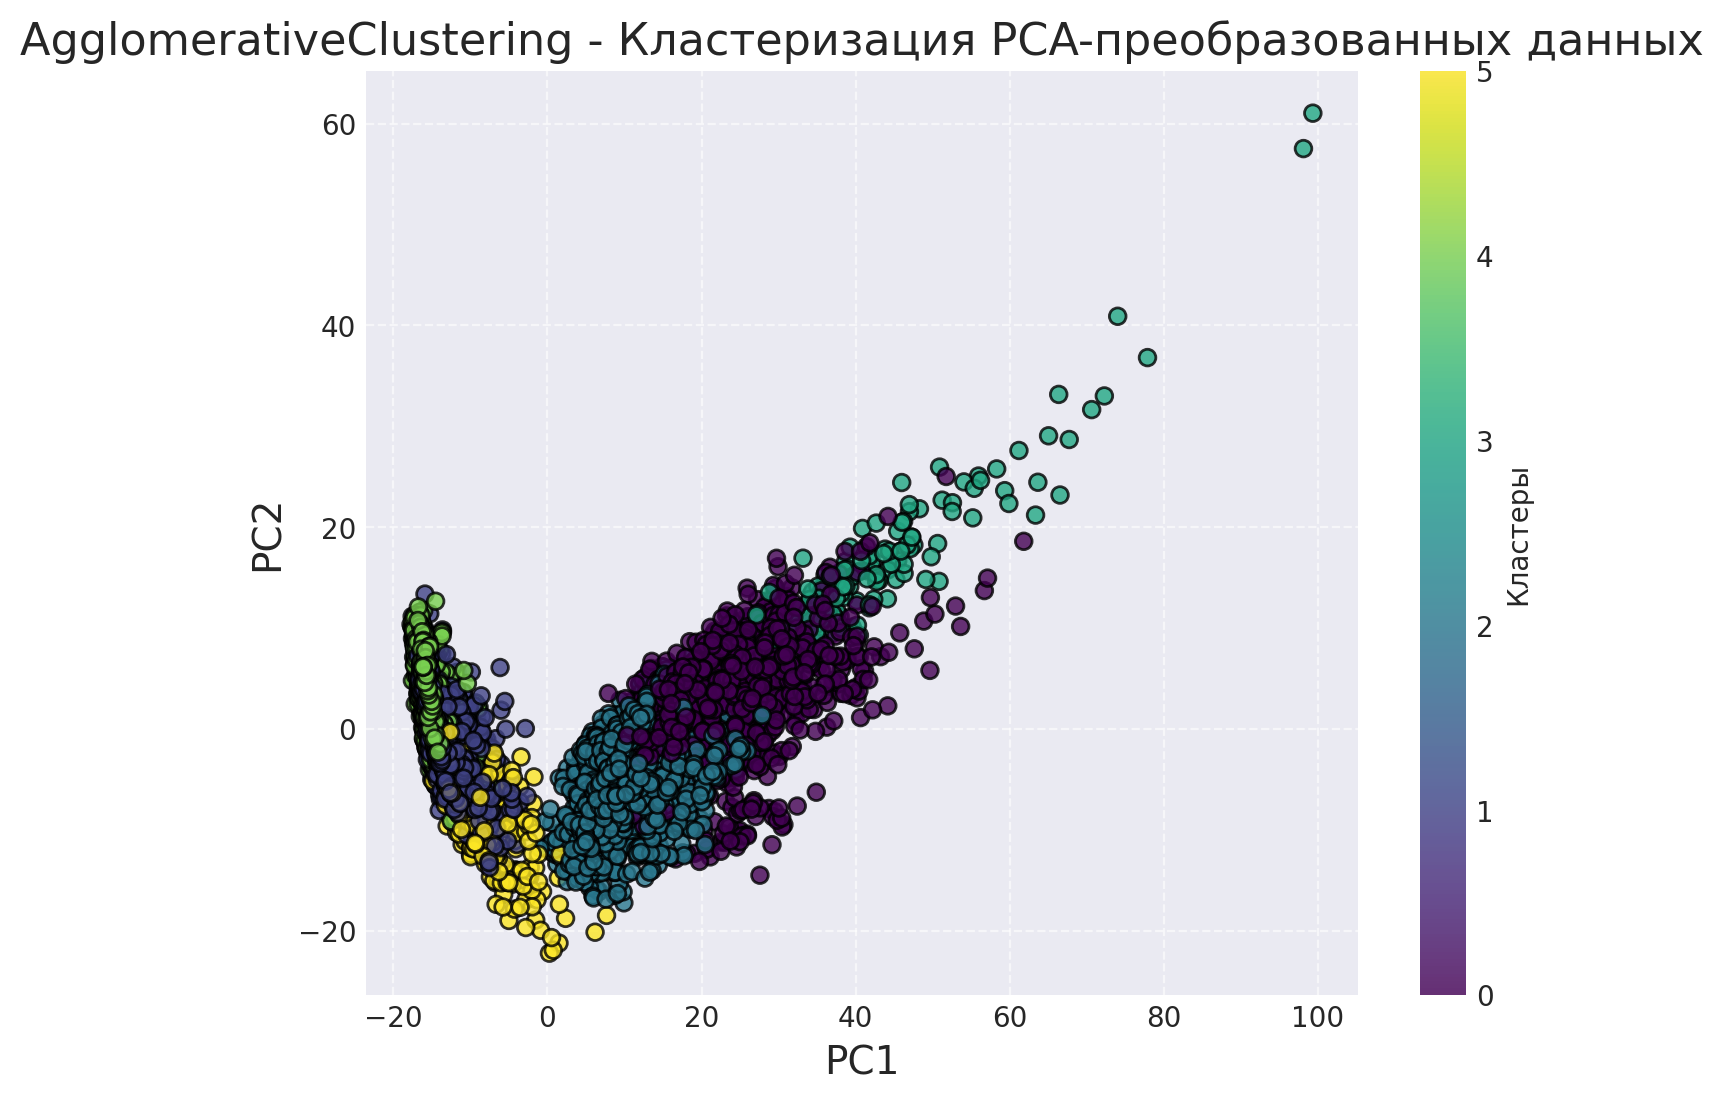

In [100]:
plt.figure(figsize=(8, 6))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_pred_agg, cmap="viridis", alpha=0.8, edgecolor='k')
plt.colorbar(scatter, label="Кластеры")
plt.title("AgglomerativeClustering - Кластеризация PCA-преобразованных данных", fontsize=16)
plt.xlabel("PC1", fontsize=14)
plt.ylabel("PC2", fontsize=14)
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

In [101]:
silhouette_agg = silhouette_score(X_pca, y_pred_agg)
davies_bouldin_agg = davies_bouldin_score(X_pca, y_pred_agg)

print(f"Средний силуэтный коэффицент (agg): {silhouette_agg:.2f}")
print(f"Индекс Дэвиса-Болдина (agg): {davies_bouldin_agg:.2f}")

Средний силуэтный коэффицент (agg): 0.14
Индекс Дэвиса-Болдина (agg): 2.04


>По сравнению с KMeans метрики практически не изменились. По графикам видно, что данные не образуют четко выраженной стрктуры, возможно, поэтому метрики такие низкие.

### **Задание 23 (0.3 балла)**
Для самой успешной из полученных кластеризаций попробуйте дать интерпретацию кластеров. Опишите характеристики объектов, попавших в каждый кластер. Для этого можете ответить на следующие вопросы:

* Похожи ли объекты внутри каждого кластера на определенный тип активности человека?
* В каких кластерах смешано несколько типов активности? С чем, на ваш взгляд, это может быть связано?
* Качественная ли получилась кластеризация? На основании чего вы можете сделать такой вывод?

>Ответим на вопросы на примере KMeans, т.к. график получился более читаемый, а метрики получились практически однаковые:  
1. Объекты внутри каждого кластера напоминают определенные типы активности человека, например, видно, что класс 5 находится вышего всего.
2. Видно, что классы 1 и 2 смешиваются, это может быть связано с тем, что пользователь выполняет похожие или одни и те же активности - ходьба и подъем по лестнице.
3. Кластеризация получилась плохой: некоторые кластеры накладываются друг на друга.

## **Бонус-задание (1 балл)**
![RedPanda](http://imgur.com/6Aa52Lm.png)

Алгоритмы кластеризации могут применяться в самых разных задачах. Например, в анализе изображений есть задача разделения изображения на семантические компоненты, которую можно решать в том числе с помощью алгоритмов кластеризации. В бонусе предлагаем вам попрактиковаться именно в этом на чудесной утке и совах (```duck.jpg``` и ```owls.jpg```)

### **(0.1 балл)**

- Откройте изображения, после чего визуализируйте их с помощью ```plt.imshow()```

In [102]:
# from PIL import Image
# # or
# #import cv2

### **(0.4 балла)**

Для каждого изображения, используя кластеризацию ```KMeans```, выделите компоненты, охарактеризовав каждый пиксель следующим образом: $$\psi_i = [\lambda x_i, \lambda y_i, r_i, g_i, b_i]$$
 где
- $x_i$ и $y_i$ — координаты пикселя,
- $r_i, g_i, b_i$ — его цвет,
- $\lambda$ — параметр, выражающий важность пространственной связности перед цветовой похожестью.

Примените полученную функцию, взяв следующие $\lambda$: 0.3 и 1.5 для ```duck.jpg``` и ```owls.jpg``` (или другие, но тогда с вас красивые результаты :) )

**Примечание:**
Число кластеров подберите разумным образом на свой вкус (в качестве нулевого приближения можно взять 3)

In [103]:
# def find_components(image, lmbd, n_clusters):
#     #your code here

### **(0.4 балла)**

Попробуйте выделить сегменты при помощи [спектральной кластеризации](http://scikit-learn.org/stable/modules/clustering.html#spectral-clustering). Обратите внимание на [пример в sklearn](http://scikit-learn.org/0.16/auto_examples/cluster/plot_lena_segmentation.html).


**Примечание:**

Для ускорения работы алгоритма рекомендуется привести изображение к серому цвету. При необходимости можно сжать изображения в 2 раза.

**Подсказка:**```skimage``` с его ```color``` и ```transform``` в этом помогут :)

Или же воспользуйтесь аналогичными средствами ```PIL``` или ```cv2```

In [104]:
# def spectral_segmentation(image, n_clusters, beta, eps):
#     #your code here

### **(0.1 балл)**
Визуализируйте результаты сегментации (аналогично рисунку в начале задания 2) для обоих методов.

**Спасибо! Вы — человек — большой трудяга!**

Успокоительный котобонус :)

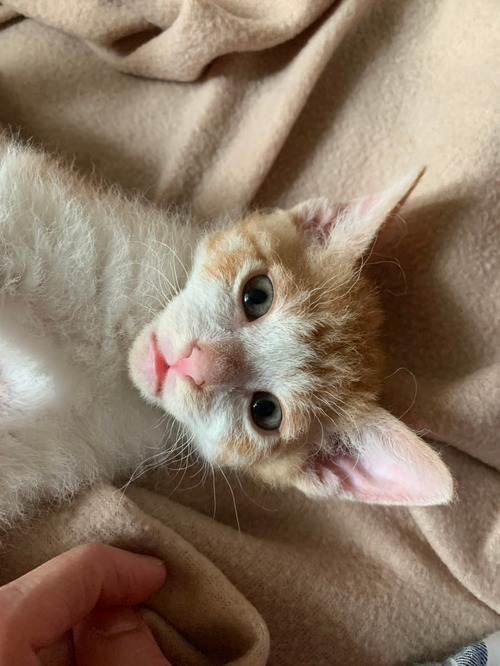

>Кот Романа :)